Please Enter Concentration in uM at Which ZPYP is Injected:	40
Please Enter Concentration in uM at Which Fc is Injected:	20
Please Enter the Volume in uL of the Injected Sample:		500
Please Enter the Light State Dissociation Constant in uM:	10
Please Enter the Dark State Dissociation Constant in uM:	40


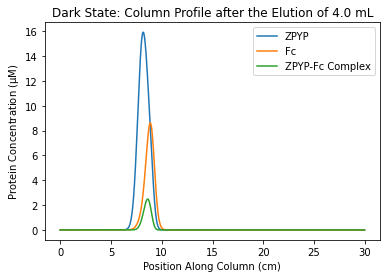

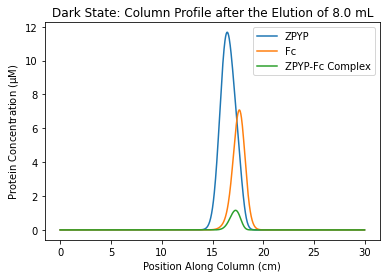

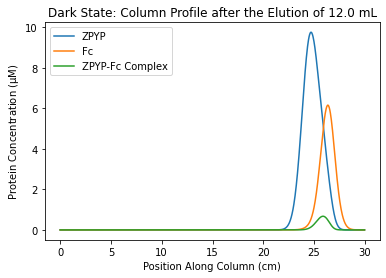

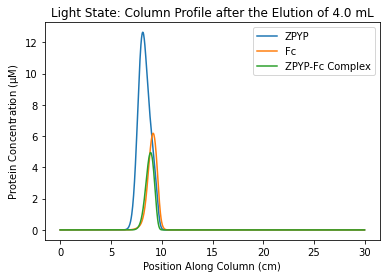

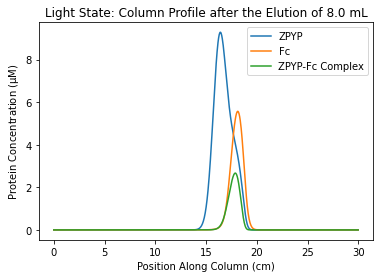

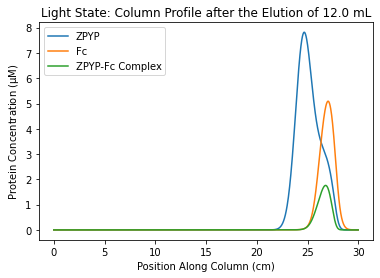

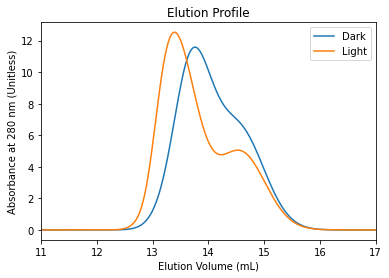

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# empirically derived partition coefficients.
probs = np.array([0.6860,0.7210,0.7935])
# empirically derived diffusion coefficients.
diffusion_constants = np.array([0.17,0.22,0.34])

L=1000
timePoints = 1700

# obtain user input.

proteinInjectionConcentration_ZPYP = float(input("Please Enter Concentration in uM at Which ZPYP is Injected:\t"))
proteinInjectionConcentration_Fc = float(input("Please Enter Concentration in uM at Which Fc is Injected:\t"))
injectionVolume = float(input("Please Enter the Volume in uL of the Injected Sample:\t\t"))
lightValue = float(input("Please Enter the Light State Dissociation Constant in uM:\t"))
darkValue = float(input("Please Enter the Dark State Dissociation Constant in uM:\t"))
k_array = np.array([darkValue,lightValue])
injectTime = injectionVolume / 500 * 20

# ZPYP values.
Z = np.zeros(L)
Z_free = np.zeros(L)
Z_stagnant = np.zeros(L)
# Fc values.
F = np.zeros(L)
F_free = np.zeros(L)
F_stagnant = np.zeros(L)
# ZPYP-Fc complex values.
ZF = np.zeros(L)
ZF_free = np.zeros(L)
ZF_stagnant = np.zeros(L)
# arrays to observe what comes off the column.
observed_dark = np.zeros(timePoints)
observed_light = np.zeros(timePoints)
# a placeholder array for calculating diffusion.
dd_P = np.zeros(L-10)

for k in k_array: 
	for i in range(timePoints):
		# inject new protein.
		if i<injectTime:
			Z_free[0] = Z_free[0] + proteinInjectionConcentration_ZPYP
			F_free[0] = F_free[0] + proteinInjectionConcentration_Fc
		
		# partition between free and stagnant phases.

		Z = Z_free + Z_stagnant
		Z_free = probs[0] * Z
		Z_stagnant = (1-probs[0]) * Z

		F = F_free + F_stagnant
		F_free = probs[1] * F
		F_stagnant = (1-probs[1]) * F

		ZF = ZF_free + ZF_stagnant
		ZF_free = probs[2] * ZF
		ZF_stagnant = (1-probs[2]) * ZF

		# calculate the new Z+F->ZF equilibrium. do this separately for the free and stagnant phases.

		Z_free = Z_free + ZF_free
		F_free = F_free + ZF_free
		alpha = Z_free + F_free + k
		ZF_free = (alpha - np.sqrt(alpha**2 - 4 * Z_free * F_free)) / 2
		Z_free = Z_free - ZF_free
		F_free = F_free - ZF_free

		Z_stagnant = Z_stagnant + ZF_stagnant
		F_stagnant = F_stagnant + ZF_stagnant
		alpha = Z_stagnant + F_stagnant + k
		ZF_stagnant = (alpha - np.sqrt(alpha**2 - 4 * Z_free * F_free)) / 2
		Z_stagnant = Z_stagnant - ZF_stagnant
		F_stagnant = F_stagnant - ZF_stagnant

		# move the free particles down the column.
		
		Z_free[1:] = Z_free[:-1]
		Z_free[0] = 0
		F_free[1:] = F_free[:-1]
		F_free[0] = 0
		ZF_free[1:] = ZF_free[:-1]
		ZF_free[0] = 0

		# apply diffusion. as it turns out applying it near column ends breaks conservation of mass so i just
		# didn't do that.

		dd_P = Z_free[4:-6] - 2 * Z_free[5:-5] + Z_free[6:-4]
		Z_free[5:-5] = Z_free[5:-5] + diffusion_constants[0] * dd_P

		dd_P = F_free[4:-6] - 2 * F_free[5:-5] + F_free[6:-4]
		F_free[5:-5] = F_free[5:-5] + diffusion_constants[1] * dd_P

		dd_P = ZF_free[4:-6] - 2 * ZF_free[5:-5] + ZF_free[6:-4]
		ZF_free[5:-5] = ZF_free[5:-5] + diffusion_constants[2] * dd_P

		dd_P = Z_stagnant[4:-6] - 2 * Z_stagnant[5:-5] + Z_stagnant[6:-4]
		Z_stagnant[5:-5] = Z_stagnant[5:-5] + diffusion_constants[0] * dd_P

		dd_P = F_stagnant[4:-6] - 2 * F_stagnant[5:-5] + F_stagnant[6:-4]
		F_stagnant[5:-5] = F_stagnant[5:-5] + diffusion_constants[1] * dd_P

		dd_P = ZF_stagnant[4:-6] - 2 * ZF_stagnant[5:-5] + ZF_stagnant[6:-4]
		ZF_stagnant[5:-5] = ZF_stagnant[5:-5] + diffusion_constants[2] * dd_P

		# take an absorbance reading. this assumes that the extinction coefficient of Fc is twice that of ZPYP.

		if k==darkValue:
			observed_dark[i] = Z_free[-1] + 2*F_free[-1] + 3*ZF_free[-1] + Z_stagnant[-1] + 2*F_stagnant[-1] + 3*ZF_stagnant[-1]
		else:
			observed_light[i] = Z_free[-1] + 2*F_free[-1] + 3*ZF_free[-1] + Z_stagnant[-1] + 2*F_stagnant[-1] + 3*ZF_stagnant[-1]
		Z_free[-1]=0
		F_free[-1]=0
		ZF_free[-1]=0
		Z_stagnant[-1]=0
		F_stagnant[-1]=0
		ZF_stagnant[-1]=0

		# graph the state of the column. don't bother showing it at the beginning or end because it looks boring.

		if i%400==0 and i>100 and i<1500:
			plt.plot(np.arange(0,30,30./L),Z_free+Z_stagnant,label="ZPYP")
			plt.plot(np.arange(0,30,30./L),F_free+F_stagnant,label="Fc")
			plt.plot(np.arange(0,30,30./L),ZF_free+ZF_stagnant,label="ZPYP-Fc Complex")
			if k==darkValue:
				plt.title("Dark State: Column Profile after the Elution of " + str(i/100.) + " mL")
			else:
				plt.title("Light State: Column Profile after the Elution of " + str(i/100.) + " mL")
			plt.xlabel("Position Along Column (cm)")
			plt.ylabel("Protein Concentration ($\mathrm{\mu}$M)")
			plt.legend()
			plt.show()

# plot the final elution profiles.

plt.plot(np.arange(0,timePoints/100.,1./100),observed_dark,label="Dark")
plt.plot(np.arange(0,timePoints/100.,1./100),observed_light,label="Light")
plt.title("Elution Profile")
plt.ylabel("Absorbance at 280 nm (Unitless)")
plt.xlabel("Elution Volume (mL)")
plt.xlim([11,17])
plt.legend()
plt.show()